# Generative Adversarial Networks (GANs)

目前为止，我们所探索过的神经网络的所有应用都是判别模型，它接受输入并经过训练产生有标记的输出。在本实验中，我们将使用神经网络构建生成模型。具体来说，我们将学习如何构建模型，生成类似于一组训练图像的新图像。

### What is a GAN?

2014年，Goodfellow等人提出了一种训练生成模型的方法，称为生成对抗网络(GANs)。在GAN中，我们建立了两个不同的神经网络。我们的第一个网络是一个传统的分类网络，称为鉴别器。我们将训练鉴别器拍摄图像并将其分类为真实的(属于训练集中)或虚假的(不存在于训练集中)。我们的另一个网络，称为生成器，将随机噪声作为输入，并使用神经网络转换它产生图像。生成器的目标是欺骗鉴别器，使其认为它产生的图像是真实的。

我们可以把生成器($G$)试图欺骗鉴别器($D$)，而鉴别器试图正确地将真假分类为一个极大极小博弈的来回过程:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
其中$z \sim p(z)$是随机噪声样本，$G(z)$是使用神经网络生成器$G$生成的图像，$D$是鉴别器的输出，指定输入为真实的概率。In [Goodfellow et al.](https://arxiv.org/abs/1406.2661),他们分析了这个极大极小对策，并展示了它如何与最小化训练数据分布和$G$生成的样本之间的Jensen-Shannon发散有关。

为了优化这个极大极小游戏，我们将在目标上的梯度下降步骤($G$)和目标上的梯度下降步骤($D$)之间交替进行:
1. 更新**生成器** ($G$)以最小化__discriminator做出正确选择的概率__。 
2. 更新**鉴别器** ($D$)以最大化__discriminator做出正确选择的概率__。

虽然这些更新对分析很有用，但在实践中表现不佳。相反，当我们更新生成器时，我们将使用不同的目标:最大化**鉴别器做出错误选择的概率**。这个小的改变有助于缓解当鉴别器有信心时生成器梯度消失的问题。这是在大多数GAN论文中使用的标准更新，并在原始论文中使用 [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

在这个实验中，我们将交替进行以下更新:
1. 更新生成器($G$)，使鉴别器在生成的数据上做出错误选择的概率最大化:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. 更新鉴别器($D$)，使鉴别器在真实和生成的数据上做出正确选择的概率最大化:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

Here's an example of what your outputs from the 3 different models you're going to train should look like. Note that GANs are sometimes finicky, so your outputs might not look exactly like this. This is just meant to be a *rough* guideline of the kind of quality you can expect:

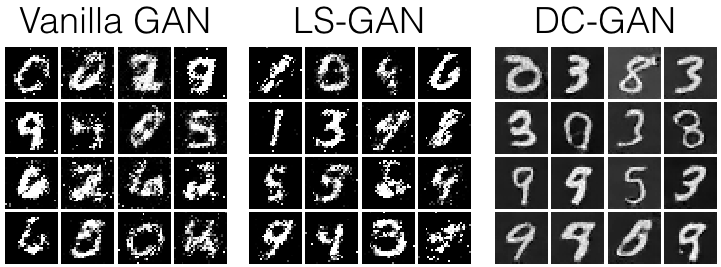

In [1]:
# Run this cell to see sample outputs.
from IPython.display import Image
Image('gan/gan_outputs_pytorch.png')

In [2]:
# Setup cell.
import numpy as np
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from GAN.gan_pytorch import preprocess_img, deprocess_img, rel_error, count_params, ChunkSampler

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1]) # Images reshape to (batch_size, D).
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

answers = dict(np.load('gan-checks.npz'))
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

## Dataset
 众所周知，GANs对超参数非常挑剔，而且还需要很多训练时间。为了使这一分配可行，我们将在MNIST数据集上工作，这是60,000个训练图像和10,000个测试图像。每张图片都包含一个黑色背景的白色数字的中心图像(0到9)。这是第一批用于训练卷积神经网络的数据集之一，它相当简单——一个标准的CNN模型可以轻松超过99%的准确率。

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

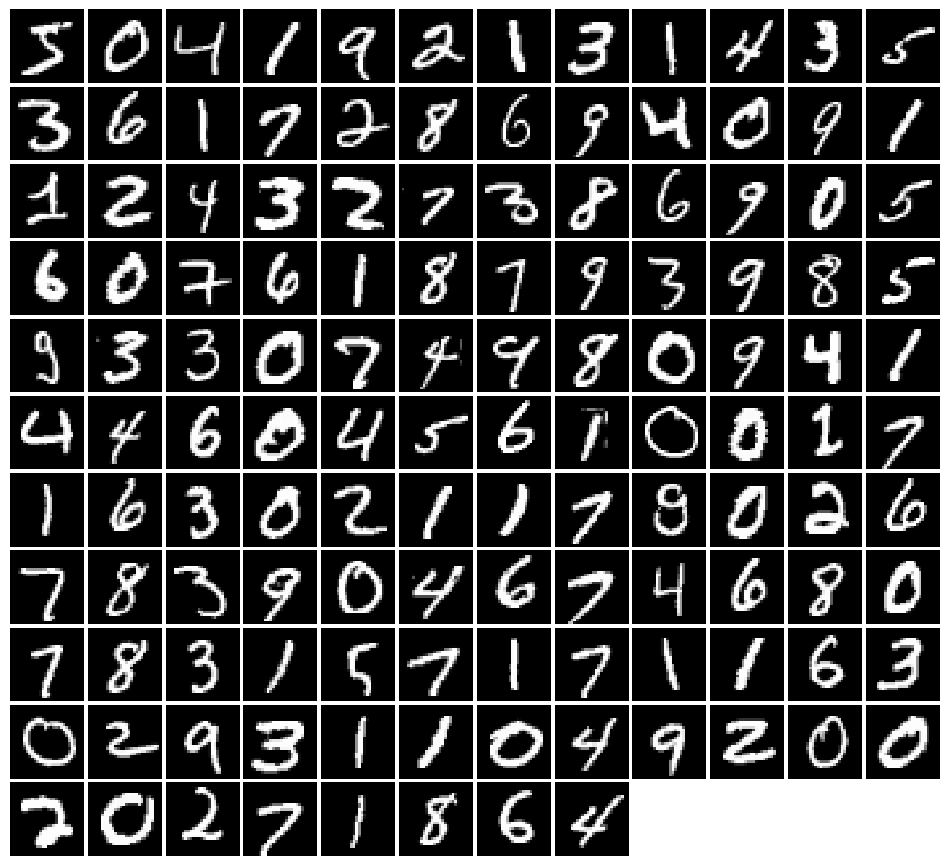

In [3]:
NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

mnist_train = dset.MNIST(
    'GAN/datasets/MNIST_data',
    train=True,
    download=True,
    transform=T.ToTensor()
)
loader_train = DataLoader(
    mnist_train,
    batch_size=batch_size,
    sampler=ChunkSampler(NUM_TRAIN, 0)
)

mnist_val = dset.MNIST(
    'GAN/datasets/MNIST_data',
    train=True,
    download=True,
    transform=T.ToTensor()
)
loader_val = DataLoader(
    mnist_val,
    batch_size=batch_size,
    sampler=ChunkSampler(NUM_VAL, NUM_TRAIN)
)

imgs = loader_train.__iter__().__next__()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

## Random Noise
Generate uniform noise from -1 to 1 with shape `[batch_size, dim]`.

实现 `sample_noise` 在 `cs231n/gan_pytorch.py`中.

Hint: use `torch.rand`.

Make sure noise is the correct shape and type:

In [4]:
from GAN.gan_pytorch import sample_noise
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

def test_sample_noise(): 
    batch_size = 3
    dim = 4
    torch.manual_seed(231)
    z = sample_noise(batch_size, dim)
    np_z = z.cpu().numpy()
    assert np_z.shape == (batch_size, dim)
    assert torch.is_tensor(z)
    assert np.all(np_z >= -1.0) and np.all(np_z <= 1.0)
    assert np.any(np_z < 0.0) and np.any(np_z > 0.0)
    print('All tests passed!')
    
test_sample_noise()

All tests passed!


## Flatten

回想一下我们之前的Flatten操作…这次我们还提供了Unflatten，你可能想在实现卷积生成器时使用它。我们还提供了一个权重初始化器，它使用Xavier初始化而不是PyTorch的统一默认值。

In [5]:
from GAN.gan_pytorch import Flatten, Unflatten, initialize_weights

# Discriminator
我们的第一步是建立一个鉴别器。 Fill in the architecture as part of the `nn.Sequential` constructor in the function below. All fully connected layers should include bias terms. The architecture is:
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input_size 256 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input size 256 and output size 1
 
Recall that the Leaky ReLU nonlinearity computes $f(x) = \max(\alpha x, x)$ for some fixed constant $\alpha$; for the LeakyReLU nonlinearities in the architecture above we set $\alpha=0.01$.
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

实现 `discriminator` 在 `cs231n/gan_pytorch.py`中

测试以确保鉴别器中的参数数量是正确的:

In [6]:
from GAN.gan_pytorch import discriminator

def test_discriminator(true_count=267009):
    model = discriminator()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in discriminator. Check your achitecture.')
    else:
        print('Correct number of parameters in discriminator.')     

test_discriminator()

Correct number of parameters in discriminator.


# Generator
Now to build the generator network:
 * Fully connected layer from noise_dim to 1024
 * `ReLU`
 * Fully connected layer with size 1024 
 * `ReLU`
 * Fully connected layer with size 784
 * `TanH` (to clip the image to be in the range of [-1,1])
 
 实现 `generator` 在 `cs231n/gan_pytorch.py`中

测试以确保生成器中的参数数量是正确的:

In [7]:
from GAN.gan_pytorch import generator

def test_generator(true_count=1858320):
    model = generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_generator()

Correct number of parameters in generator.


# GAN Loss

计算生成器和鉴别器损失。 生成器损失为:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
鉴别器损失为:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: 应该使用下面定义的' bce_loss '函数来计算二元交叉熵损失，它需要计算真标签的log概率，给定鉴别器的logits输出。 Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$

这个公式的简单实现可能在数字上不稳定，所以我们提供了一个数字稳定的实现，它依赖PyTorch的' nn.BCEWithLogitsLoss '。

还需要计算对应于real或fake的标签，并使用logit参数来确定它们的大小。确保你使用全局' dtype '变量将这些标签转换为正确的数据类型，例如:


`true_labels = torch.ones(size).type(dtype)`

Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch. This is taken care of in `bce_loss` which combines the loss by averaging.

完成 `discriminator_loss` and `generator_loss` 在 `cs231n/gan_pytorch.py`中

Test your generator and discriminator loss. You should see errors < 1e-7.

In [8]:
from GAN.gan_pytorch import bce_loss, discriminator_loss, generator_loss

def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(torch.Tensor(logits_real).type(dtype),
                                torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(answers['logits_real'], 
                        answers['logits_fake'],
                        answers['d_loss_true']) 


Maximum error in d_loss: 3.97058e-09


In [9]:
def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(
    answers['logits_fake'],
    answers['g_loss_true']
)

Maximum error in g_loss: 4.4518e-09


# Optimizing our Loss
Make a function that returns an `optim.Adam` optimizer for the given model with a 1e-3 learning rate, beta1=0.5, beta2=0.999. You'll use this to construct optimizers for the generators and discriminators for the rest of the notebook.

完成 `get_optimizer` 在 `cs231n/gan_pytorch.py`中

# Training a GAN!

为你提供了主要的训练循环。你不需要更改cs231n/gan_pytorch.py中的run_a_gan，但鼓励你通读它以理解它。

In [10]:
from GAN.gan_pytorch import get_optimizer, run_a_gan

# Make the discriminator
D = discriminator().type(dtype)

# Make the generator
G = generator().type(dtype)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)

# Run it!
images = run_a_gan(
    D,
    G,
    D_solver,
    G_solver,
    discriminator_loss,
    generator_loss,
    loader_train
)

Iter: 0, D: 1.328, G:0.7202
Iter: 250, D: 1.01, G:1.129
Iter: 500, D: 1.441, G:1.651
Iter: 750, D: 1.197, G:0.9856
Iter: 1000, D: 1.303, G:0.9966
Iter: 1250, D: 1.189, G:1.222
Iter: 1500, D: 1.21, G:1.101
Iter: 1750, D: 1.278, G:0.8168
Iter: 2000, D: 1.249, G:0.8752
Iter: 2250, D: 1.307, G:0.8027
Iter: 2500, D: 1.232, G:0.8753
Iter: 2750, D: 1.325, G:0.8142
Iter: 3000, D: 1.279, G:0.8156
Iter: 3250, D: 1.288, G:0.762
Iter: 3500, D: 1.26, G:0.7578
Iter: 3750, D: 1.334, G:0.8029


Run the cell below to show the generated images.

Iter: 0


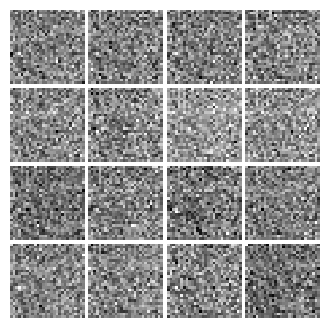


Iter: 250


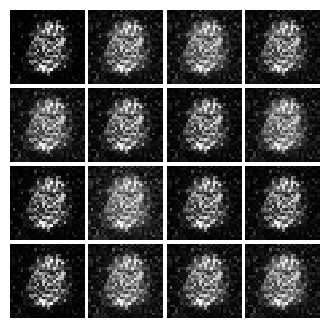


Iter: 500


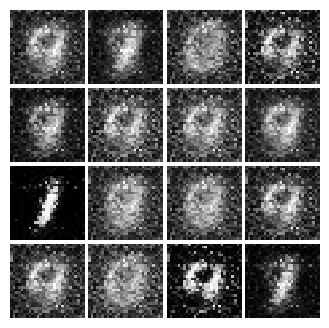


Iter: 750


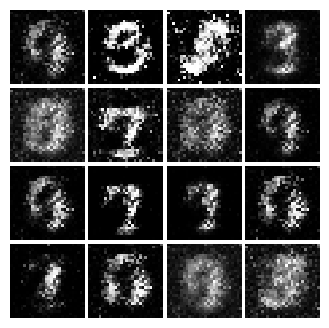


Iter: 1000


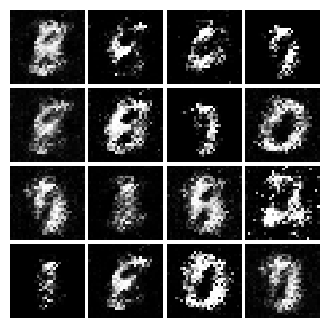


Iter: 1250


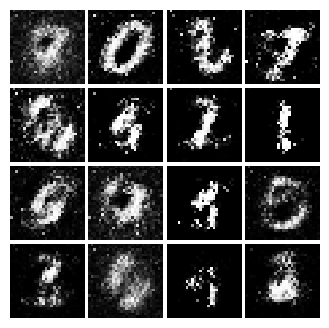


Iter: 1500


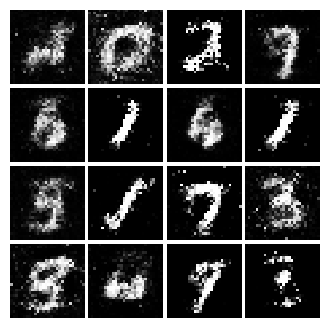


Iter: 1750


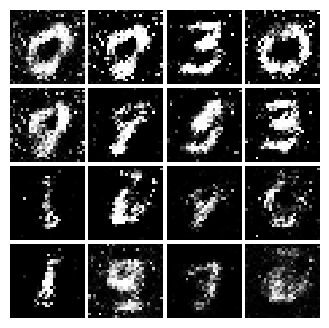


Iter: 2000


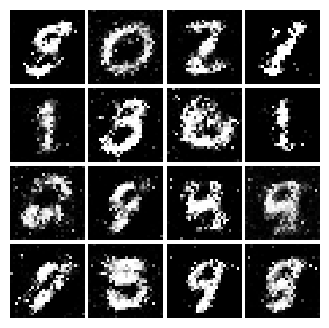


Iter: 2250


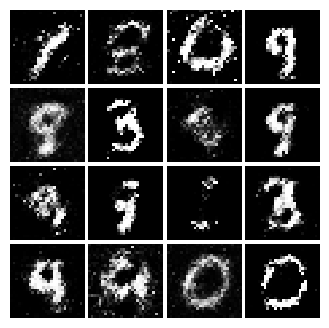


Iter: 2500


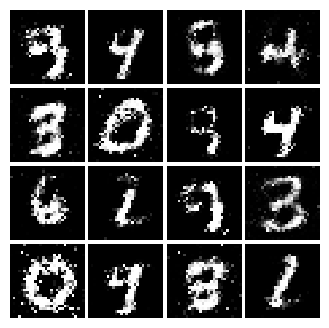


Iter: 2750


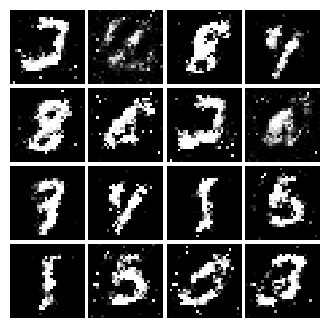


Iter: 3000


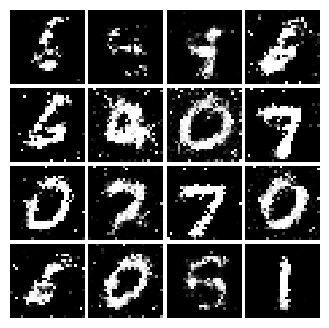


Iter: 3250


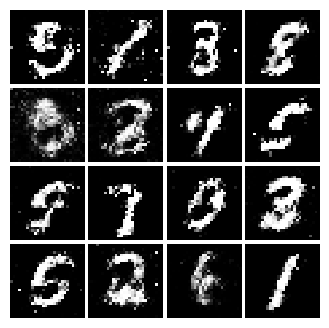


Iter: 3500


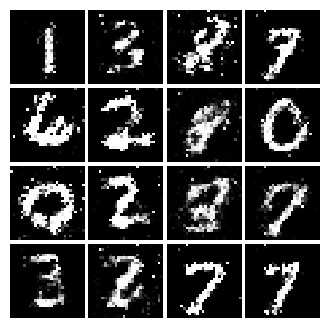


Iter: 3750


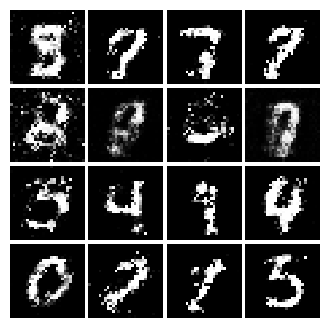

In [11]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

## Inline Question 1

What does your final vanilla GAN image look like?

Vanilla GAN final image:


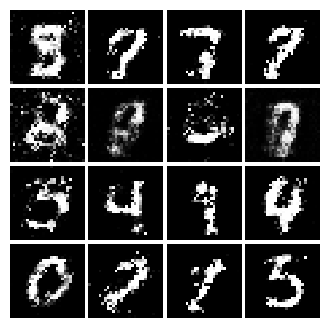

In [12]:
# This output is your answer.
print("Vanilla GAN final image:")
show_images(images[-1])
plt.show()

在100次迭代中，当你接近迭代1000次时，你应该会看到黑色的背景，模糊的形状，以及不错的形状，当我们超过3000次时，大约一半的形状将会清晰可见。

# Least Squares GAN
现在我们来看看最小二乘GAN，一种更稳定的GAN损失函数。对于这部分，我们所要做的就是改变损失函数并重新训练模型。本文实现式(9)，其中生成器损失为:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
鉴别器损失:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

实现 `ls_discriminator_loss`, `ls_generator_loss` 在 `cs231n/gan_pytorch.py`中

在使用新的损失函数运行GAN之前，让我们检查一下:

In [13]:
from GAN.gan_pytorch import ls_discriminator_loss, ls_generator_loss

def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    score_real = torch.Tensor(score_real).type(dtype)
    score_fake = torch.Tensor(score_fake).type(dtype)
    d_loss = ls_discriminator_loss(score_real, score_fake).cpu().numpy()
    g_loss = ls_generator_loss(score_fake).cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(
    answers['logits_real'],
    answers['logits_fake'],
    answers['d_loss_lsgan_true'],
    answers['g_loss_lsgan_true']
)

Maximum error in d_loss: 1.53171e-08
Maximum error in g_loss: 2.7837e-09


运行以下单元格来训练您的模型!

In [14]:
D_LS = discriminator().type(dtype)
G_LS = generator().type(dtype)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

images = run_a_gan(
    D_LS,
    G_LS,
    D_LS_solver,
    G_LS_solver,
    ls_discriminator_loss,
    ls_generator_loss,
    loader_train
)

Iter: 0, D: 0.5689, G:0.51
Iter: 250, D: 0.1291, G:0.4026
Iter: 500, D: 0.214, G:0.2158
Iter: 750, D: 0.1785, G:0.3449
Iter: 1000, D: 0.2127, G:0.252
Iter: 1250, D: 0.1455, G:0.3046
Iter: 1500, D: 0.1743, G:0.2994
Iter: 1750, D: 0.2042, G:0.2389
Iter: 2000, D: 0.1976, G:0.2167
Iter: 2250, D: 0.1977, G:0.2183
Iter: 2500, D: 0.2144, G:0.183
Iter: 2750, D: 0.2163, G:0.1945
Iter: 3000, D: 0.2399, G:0.1359
Iter: 3250, D: 0.2164, G:0.1613
Iter: 3500, D: 0.2244, G:0.1673
Iter: 3750, D: 0.2377, G:0.1619


Run the cell below to show generated images.

Iter: 0


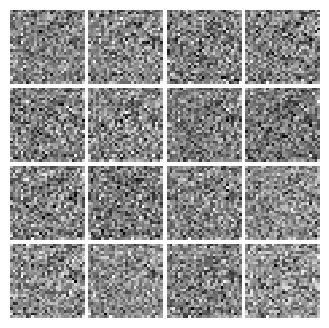


Iter: 250


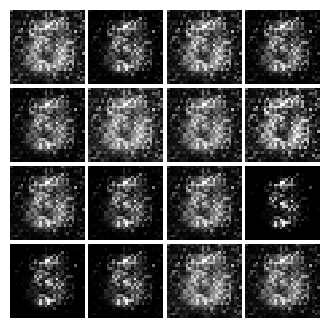


Iter: 500


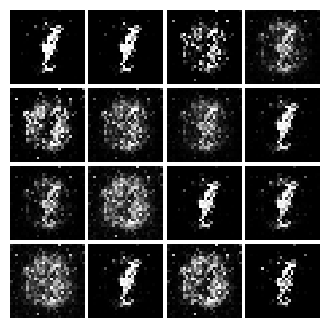


Iter: 750


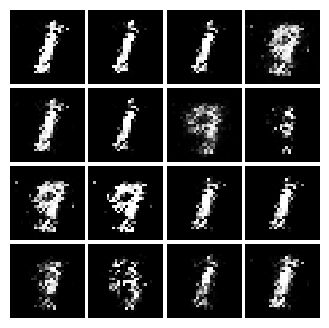


Iter: 1000


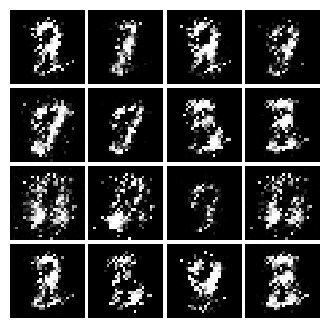


Iter: 1250


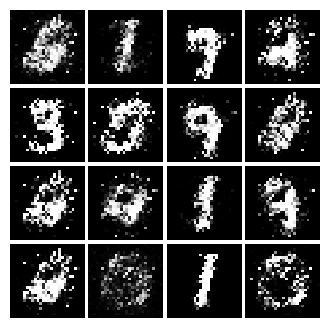


Iter: 1500


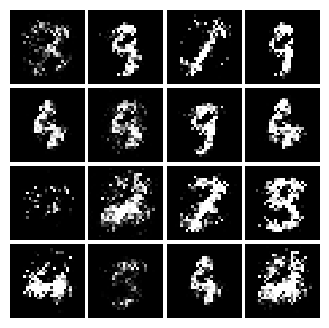


Iter: 1750


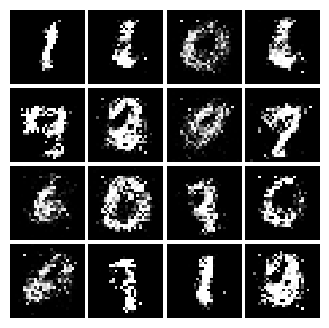


Iter: 2000


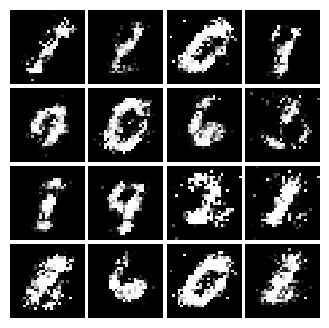


Iter: 2250


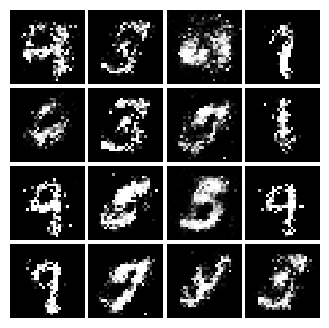


Iter: 2500


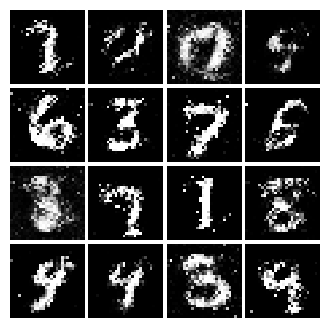


Iter: 2750


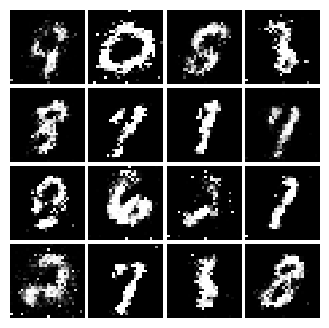


Iter: 3000


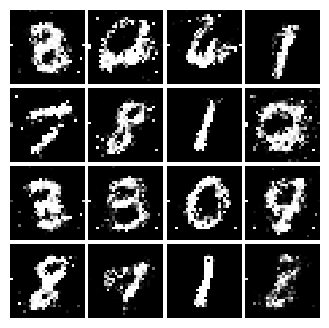


Iter: 3250


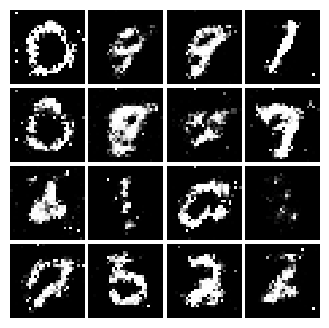


Iter: 3500


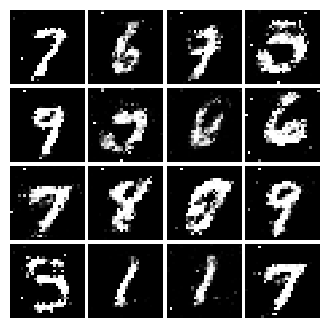


Iter: 3750


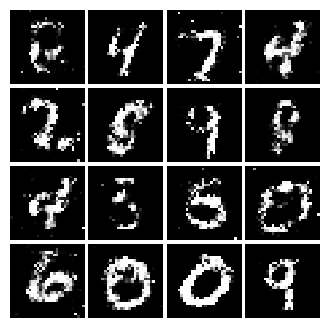

In [15]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

## Inline Question 2

What does your final LSGAN image look like?

LSGAN final image:


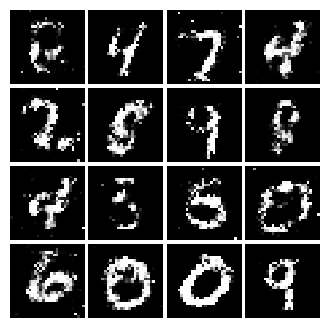

In [16]:
# This output is your answer.
print("LSGAN final image:")
show_images(images[-1])
plt.show()

# Deeply Convolutional GANs
在本实验的第一部分中，我们几乎直接复制了Ian Goodfellow提供的原始GAN网络。然而，这种网络架构不允许真正的空间推理。由于缺乏卷积层，它无法对诸如“锋利边缘”之类的东西进行预测。因此，在本节中，我们将实现来自[DCGAN](https://arxiv.org/abs/1511.06434)的一些思想，其中我们使用了卷积网络

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification tutorial, which is able to get above 99% accuracy on the MNIST dataset fairly quickly. 
* Conv2D: 32 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

实现 `build_dc_classifier` 在 `cs231n/gan_pytorch.py`中

In [17]:
from GAN.gan_pytorch import build_dc_classifier

data = next(enumerate(loader_train))[-1][0].type(dtype)
b = build_dc_classifier(batch_size).type(dtype)
out = b(data)
print(out.size())

torch.Size([128, 1])


检查分类器中的参数数量作为完整性检查:

In [18]:
def test_dc_classifer(true_count=1102721):
    model = build_dc_classifier(batch_size)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in classifier. Check your achitecture.')
    else:
        print('Correct number of parameters in classifier.')

test_dc_classifer()

Correct number of parameters in classifier.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [nn.ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html). We are always "training" in GAN mode. 
* Fully connected with output size 1024
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128 
* ReLU
* BatchNorm
* Use `Unflatten()` to reshape into Image Tensor of shape 7, 7, 128
* ConvTranspose2d: 64 filters of 4x4, stride 2, 'same' padding (use `padding=1`)
* `ReLU`
* BatchNorm
* ConvTranspose2d: 1 filter of 4x4, stride 2, 'same' padding (use `padding=1`)
* `TanH`
* Should have a 28x28x1 image, reshape back into 784 vector (using `Flatten()`)

完成 `build_dc_generator` 在 `cs231n/gan_pytorch.py`中

In [19]:
from GAN.gan_pytorch import build_dc_generator

test_g_gan = build_dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(batch_size, NOISE_DIM).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([128, 784])

Check the number of parameters in your generator as a sanity check:

In [20]:
def test_dc_generator(true_count=6580801):
    model = build_dc_generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_generator()

Correct number of parameters in generator.


In [21]:
D_DC = build_dc_classifier(batch_size).type(dtype) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

images = run_a_gan(
    D_DC,
    G_DC,
    D_DC_solver,
    G_DC_solver,
    discriminator_loss,
    generator_loss,
    loader_train,
    # num_epochs=5
)

Iter: 0, D: 1.318, G:0.8191
Iter: 250, D: 1.261, G:0.9359
Iter: 500, D: 1.193, G:1.237
Iter: 750, D: 1.172, G:0.9076
Iter: 1000, D: 1.322, G:1.034
Iter: 1250, D: 1.238, G:0.8681
Iter: 1500, D: 1.09, G:0.9438
Iter: 1750, D: 0.9924, G:1.067
Iter: 2000, D: 1.054, G:0.9836
Iter: 2250, D: 1.165, G:0.7213
Iter: 2500, D: 0.9332, G:1.255
Iter: 2750, D: 1.006, G:1.117
Iter: 3000, D: 1.024, G:0.8881
Iter: 3250, D: 0.9609, G:0.9129
Iter: 3500, D: 0.9948, G:1.148
Iter: 3750, D: 0.7677, G:2.002


Run the cell below to show generated images.

Iter: 0


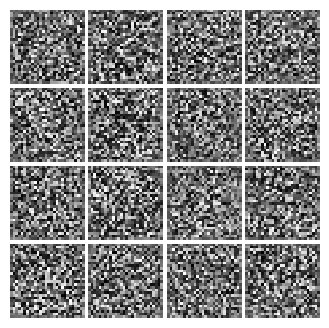


Iter: 250


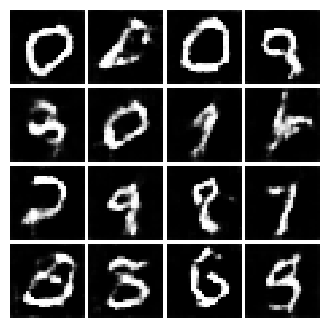


Iter: 500


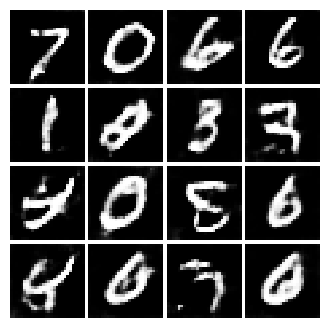


Iter: 750


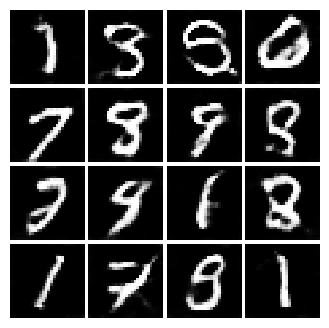


Iter: 1000


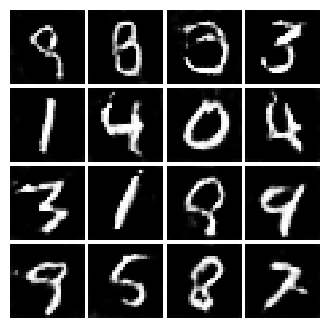


Iter: 1250


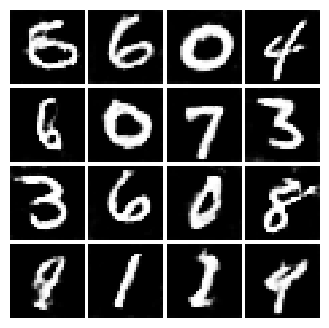


Iter: 1500


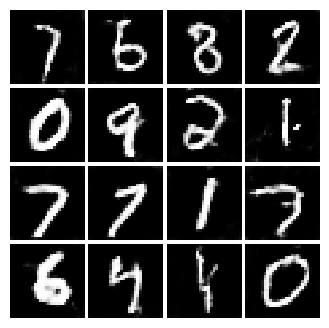


Iter: 1750


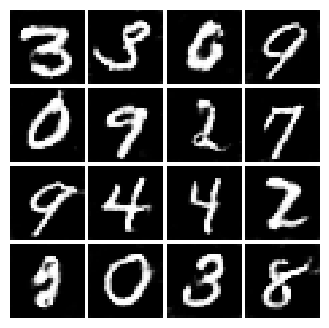


Iter: 2000


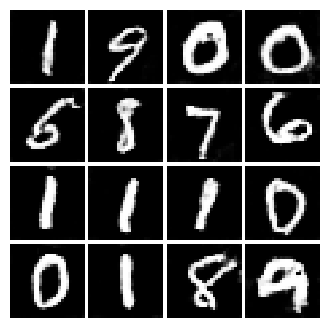


Iter: 2250


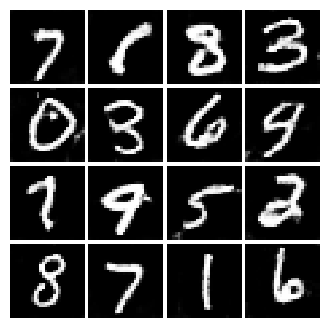


Iter: 2500


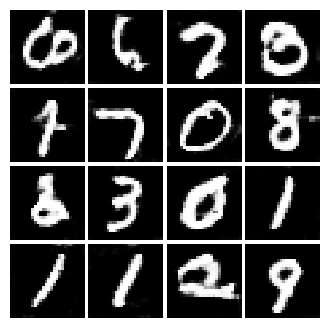


Iter: 2750


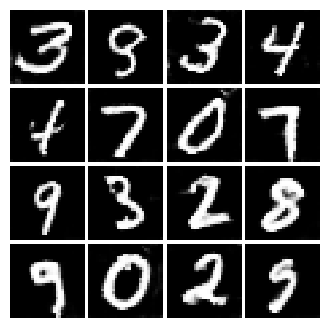


Iter: 3000


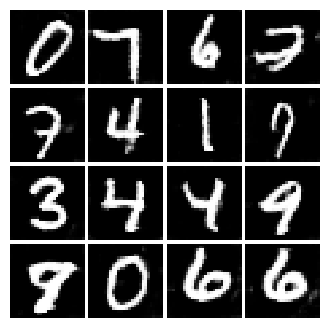


Iter: 3250


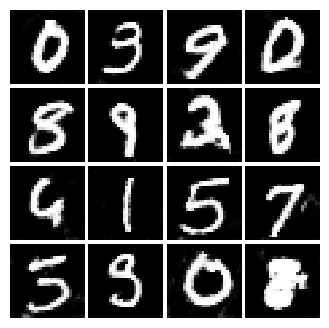


Iter: 3500


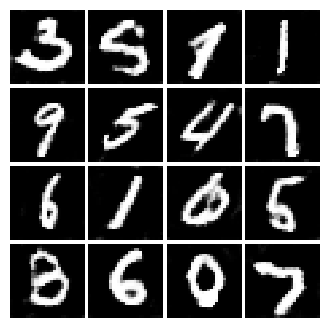


Iter: 3750


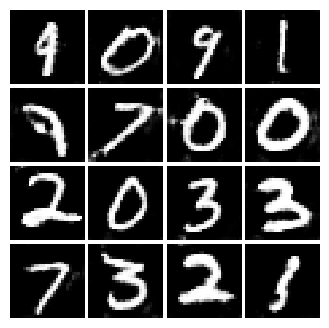

In [22]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

## Inline Question 3

What does your final DCGAN image look like?

DCGAN final image:


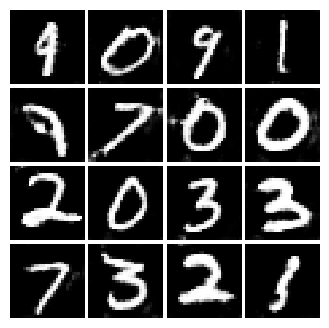

In [23]:
# This output is your answer.
print("DCGAN final image:")
show_images(images[-1])
plt.show()